In [40]:
# 📥 1. Import Libraries
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [41]:
# 📁 2. Load Dataset
df = pd.read_csv('/kaggle/input/consumer-complaints/complaint_data.csv')
df.columns = df.columns.str.strip()  # remove extra spaces in column names
df = df[['Product', 'Consumer complaint narrative']].dropna()
df = df.rename(columns={
    'Product': 'label',
    'Consumer complaint narrative': 'complaint'
})

print("Original dataset shape:", df.shape)


Original dataset shape: (481087, 2)


In [42]:
# 🧪 3. Sample Data for Faster Processing
df_sample = df.sample(10000, random_state=42)  # You can increase later


In [43]:
# ✨ 4. Define Faster Text Cleaning Function (no stemming)
# Offline stopwords
stop_words = set("""
i me my myself we our ours ourselves you your yours yourself yourselves he him his himself
she her hers herself it its itself they them their theirs themselves what which who whom
this that these those am is are was were be been being have has had having do does did doing
a an the and but if or because as until while of at by for with about against between into
through during before after above below to from up down in out on off over under again
further then once here there when where why how all any both each few more most other some
such no nor not only own same so than too very s t can will just don don should now
""".split())

def clean_text_fast(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_sample['cleaned_complaint'] = df_sample['complaint'].apply(clean_text_fast)


In [44]:
# 🧠 TF-IDF Vectorization (Run this cell first!)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_sample['cleaned_complaint'])

# 🎯 Label encoding
le = LabelEncoder()
y = le.fit_transform(df_sample['label'])

print("Feature matrix shape:", X.shape)
print("Number of labels:", len(set(y)))


Feature matrix shape: (10000, 5000)
Number of labels: 18


In [45]:
# 🏋️‍♂️ 6. Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get only the classes that appear in y_test
test_labels = np.unique(y_test)
target_names = le.inverse_transform(test_labels)  # convert integers back to original labels

# Now print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, labels=test_labels, target_names=target_names))


Classification Report:

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.36      0.29      0.32        56
                                                 Checking or savings account       0.60      0.48      0.54        87
                                                               Consumer Loan       0.43      0.06      0.11        49
                                                                 Credit card       0.50      0.22      0.31        86
                                                 Credit card or prepaid card       0.53      0.61      0.57       131
                                                            Credit reporting       0.57      0.03      0.06       134
Credit reporting, credit repair services, or other personal consumer reports       0.62      0.90      0.73       538
                               

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


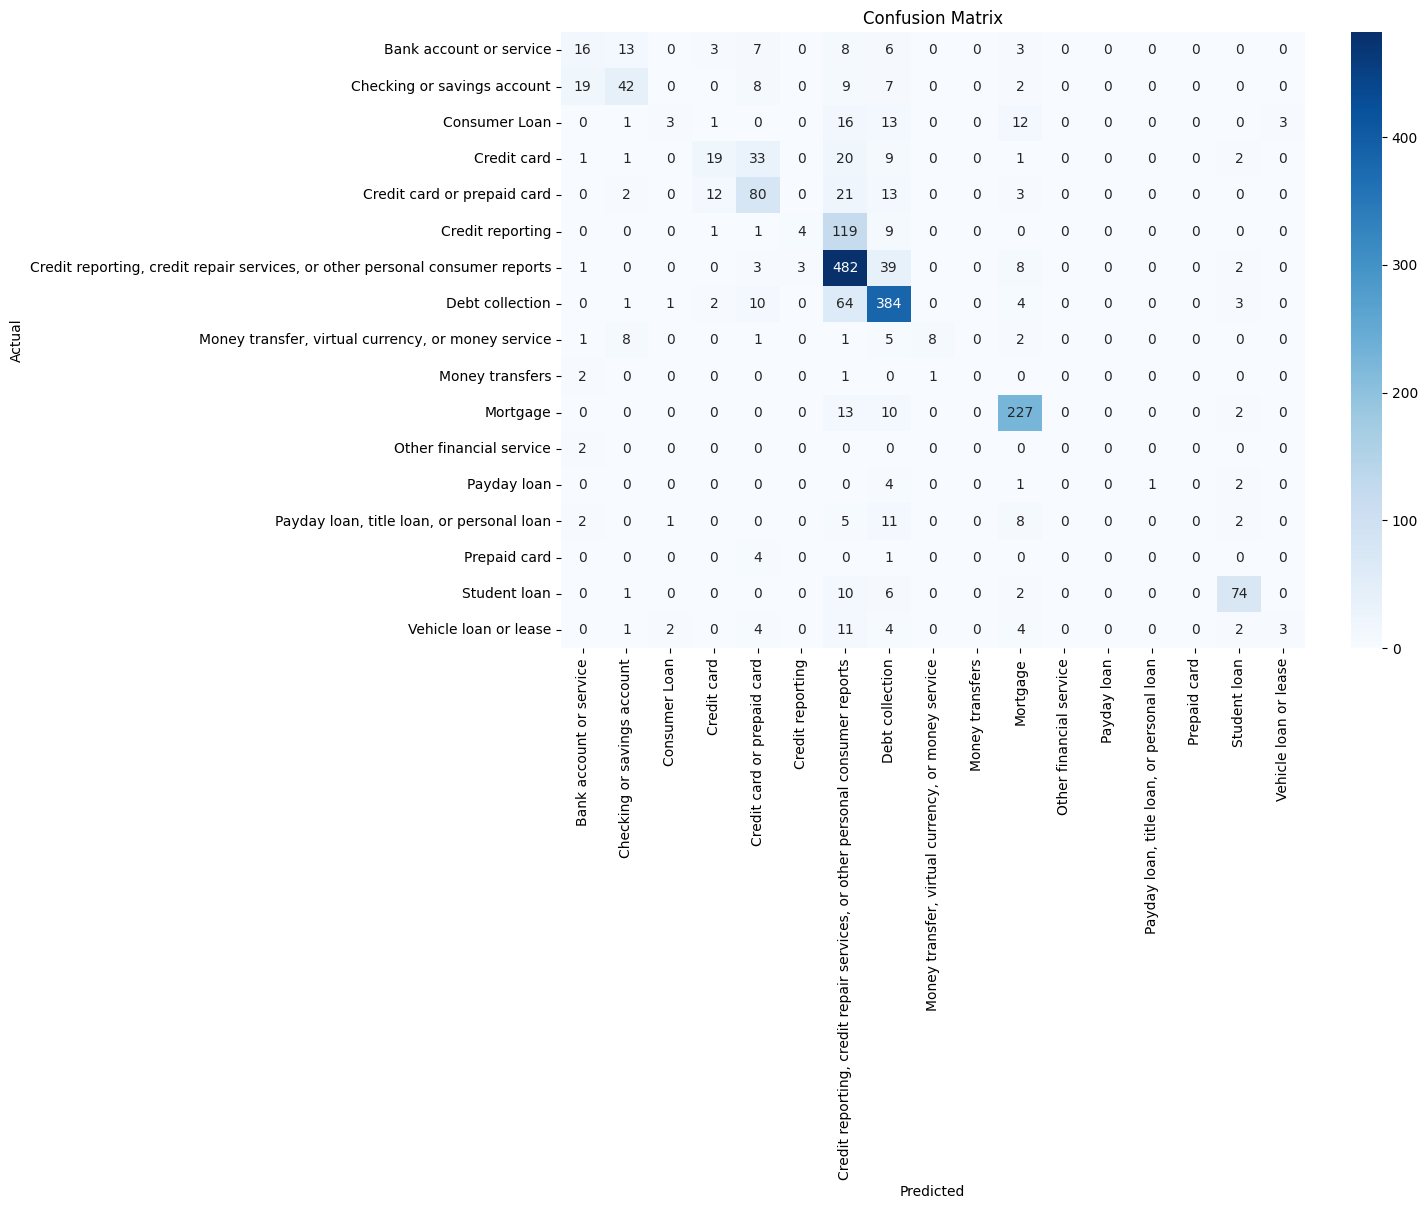

In [47]:
cm = confusion_matrix(y_test, y_pred, labels=test_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [48]:
# 💾 8. Save Model & Vectorizer
joblib.dump(model, "/kaggle/working/logistic_model.pkl")
joblib.dump(vectorizer, "/kaggle/working/tfidf_vectorizer.pkl")


['/kaggle/working/tfidf_vectorizer.pkl']

In [49]:
def predict_complaint(text):
    cleaned = clean_text_fast(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)
    return le.inverse_transform(pred)[0]
